<a href="https://colab.research.google.com/github/Khamidrees/Speech-recognition-AI-code-by-Khalid-Muhammad-Idris-/blob/main/Dsn_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


DATA_PATH = "/content/drive/MyDrive"

import os
TRAIN_FILE = os.path.join(DATA_PATH, "train.csv")
TEST_FILE = os.path.join(DATA_PATH, "test.csv")
SUBMISSION_PATH = os.path.join(DATA_PATH, "submission.csv")
RANDOM_STATE = 42

print("TRAIN_FILE:", TRAIN_FILE)
print("TEST_FILE:", TEST_FILE)
print("SUBMISSION_PATH:", SUBMISSION_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TRAIN_FILE: /content/drive/MyDrive/train.csv
TEST_FILE: /content/drive/MyDrive/test.csv
SUBMISSION_PATH: /content/drive/MyDrive/submission.csv


In [ ]:

import pandas as pd
import numpy as np
import re
import os
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import joblib

print("pandas:", pd.__version__, "sklearn:", __import__('sklearn').__version__)

pandas: 2.2.2 sklearn: 1.6.1


In [ ]:


def clean_price(x):
    if pd.isnull(x):
        return np.nan
    s = str(x).replace('$','').replace(',','').strip()
    s = re.sub(r'[^\d.]', '', s)
    return float(s) if s not in ('', '.') else np.nan

def clean_mileage(x):
    if pd.isnull(x):
        return np.nan
    s = str(x).lower().replace('mi','').replace('miles','').replace(',','').strip()
    s = re.sub(r'[^\d.]', '', s)
    return float(s) if s not in ('', '.') else np.nan

def extract_hp_engine(engine):
    if pd.isnull(engine):
        return (np.nan, np.nan)
    s = str(engine)
    hp = np.nan
    eng = np.nan
    hp_m = re.search(r'(\d{2,4}(?:\.\d+)?)\s*hp', s, re.IGNORECASE)
    if hp_m:
        hp = float(hp_m.group(1))
    else:
        hp_m = re.search(r'(\d{2,4}(?:\.\d+)?)hp', s, re.IGNORECASE)
        if hp_m:
            hp = float(hp_m.group(1))
    eng_m = re.search(r'(\d+(?:\.\d+)?)\s*l', s, re.IGNORECASE)
    if eng_m:
        eng = float(eng_m.group(1))
    return hp, eng

def simplify_accident(x):
    if pd.isnull(x):
        return -1
    s = str(x).lower()
    if 'none' in s:
        return 0
    if 'accident' in s or 'damage' in s or 'reported' in s:
        return 1
    return -1

def clean_yes_no(x):
    if pd.isnull(x):
        return -1
    s = str(x).strip().lower()
    if s in ('yes','y','true','t','1'):
        return 1
    if s in ('no','n','false','f','0'):
        return 0
    return -1

In [ ]:

def preprocess(df, is_train=True, current_year=None):
    df = df.copy()
    if current_year is None:
        current_year = datetime.now().year


    if is_train and 'price' in df.columns:
        df['price'] = df['price'].apply(clean_price)

    if 'milage' in df.columns:
        df['mileage'] = df['milage'].apply(clean_mileage)
    elif 'mileage' in df.columns:
        df['mileage'] = df['mileage'].apply(clean_mileage)
    else:
        df['mileage'] = np.nan


    if 'model_year' in df.columns:
        df['car_age'] = current_year - df['model_year']
    else:
        df['car_age'] = np.nan

    if 'engine' in df.columns:
        hp_list, eng_list = [], []
        for e in df['engine'].fillna(''):
            hp, eng = extract_hp_engine(e)
            hp_list.append(hp)
            eng_list.append(eng)
    else:
        hp_list = [np.nan]*len(df)
        eng_list = [np.nan]*len(df)
    df['hp'] = hp_list
    df['engine_size_l'] = eng_list


    if 'accident' in df.columns:
        df['accident_flag'] = df['accident'].apply(simplify_accident)
    else:
        df['accident_flag'] = -1
    if 'clean_title' in df.columns:
        df['clean_title_flag'] = df['clean_title'].apply(clean_yes_no)
    else:
        df['clean_title_flag'] = -1


    if 'transmission' in df.columns:
        df['transmission_simple'] = df['transmission'].astype(str).str.lower().fillna('unknown')
        df['transmission_simple'] = df['transmission_simple'].apply(
            lambda x: 'manual' if 'manual' in x else ('automatic' if 'auto' in x or 'automatic' in x else x)
        )
    else:
        df['transmission_simple'] = 'unknown'


    for col in ['ext_col','int_col','brand','model','fuel_type']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown').astype(str)
        else:
            df[col] = 'Unknown'


    df['hp'] = pd.to_numeric(df['hp'], errors='coerce')
    df['engine_size_l'] = pd.to_numeric(df['engine_size_l'], errors='coerce')
    df['hp'].fillna(df['hp'].median(), inplace=True)
    df['engine_size_l'].fillna(df['engine_size_l'].median(), inplace=True)
    df['mileage'].fillna(df['mileage'].median(), inplace=True)


    if is_train and 'price' in df.columns:
        before = len(df)
        df = df[~df['price'].isnull()].reset_index(drop=True)
        after = len(df)
        if before != after:
            print(f"Dropped {before-after} rows with missing price")

    return df

In [ ]:

from sklearn.preprocessing import OrdinalEncoder

def get_feature_matrix(df, encoder=None):
    features = ['brand','model','car_age','mileage','fuel_type',
                'transmission_simple','ext_col','int_col',
                'accident_flag','clean_title_flag','hp','engine_size_l']
    X = df[features].copy()
    cat_cols = ['brand','model','fuel_type','transmission_simple','ext_col','int_col']

    if encoder is None:
        enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X[cat_cols] = enc.fit_transform(X[cat_cols])
        return X, enc
    else:
        X[cat_cols] = encoder.transform(X[cat_cols])
        return X, None

In [ ]:

if not os.path.exists(TRAIN_FILE):
    raise FileNotFoundError(f"Train file not found at {TRAIN_FILE}")
if not os.path.exists(TEST_FILE):
    raise FileNotFoundError(f"Test file not found at {TEST_FILE}")

train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)

print("Raw train shape:", train.shape)
print("Raw test shape:", test.shape)

train = preprocess(train, is_train=True)
test  = preprocess(test, is_train=False)

print("Processed train shape:", train.shape)
print("Processed test shape:", test.shape)

display(train.head())

Raw train shape: (188533, 13)
Raw test shape: (125690, 12)


/tmp/ipython-input-76210157.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hp'].fillna(df['hp'].median(), inplace=True)
/tmp/ipython-input-76210157.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

Processed train shape: (188533, 20)
Processed test shape: (125690, 19)


/tmp/ipython-input-76210157.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hp'].fillna(df['hp'].median(), inplace=True)
/tmp/ipython-input-76210157.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,mileage,car_age,hp,engine_size_l,accident_flag,clean_title_flag,transmission_simple
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,213000.0,18,172.0,1.6,0,1,a/t
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,143250.0,23,252.0,3.9,1,1,a/t
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,136731.0,23,320.0,5.3,0,1,a/t
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,19500.0,8,420.0,5.0,0,1,transmission w/dual shift mode
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,7388.0,4,208.0,2.0,0,1,7-speed a/t


In [ ]:

X, encoder = get_feature_matrix(train, encoder=None)
y = train['price'].values
X_test, _ = get_feature_matrix(test, encoder=encoder)

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def rmse_cv(model, X, y, kf=kf):
    rmses = []
    for train_idx, val_idx in kf.split(X):
        Xtr, Xval = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yval = y[train_idx], y[val_idx]
        model.fit(Xtr, ytr)
        preds = model.predict(Xval)
        rmses.append(np.sqrt(mean_squared_error(yval, preds)))
    return np.mean(rmses), np.std(rmses)


rf = RandomForestRegressor(n_estimators=120, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=RANDOM_STATE)

print("Running CV for RandomForest (may take a few minutes)...")
rf_mean, rf_std = rmse_cv(rf, X, y)
print(f"RF 5-fold RMSE: {rf_mean:.2f} ± {rf_std:.2f}")

print("Running CV for GradientBoosting...")
gbr_mean, gbr_std = rmse_cv(gbr, X, y)
print(f"GBR 5-fold RMSE: {gbr_mean:.2f} ± {gbr_std:.2f}")

Running CV for RandomForest (may take a few minutes)...
RF 5-fold RMSE: 75499.27 ± 3360.11
Running CV for GradientBoosting...
GBR 5-fold RMSE: 73532.28 ± 3576.13


In [ ]:

rf.fit(X, y)
gbr.fit(X, y)

preds_rf = rf.predict(X_test)
preds_gbr = gbr.predict(X_test)
preds = (preds_rf + preds_gbr) / 2.0


if 'id' in test.columns:
    ids = test['id']
else:
    ids = np.arange(1, len(preds) + 1)

submission = pd.DataFrame({'id': ids, 'price': preds})
submission.to_csv(SUBMISSION_PATH, index=False)
print("Saved submission to:", SUBMISSION_PATH)
display(submission.head())

Saved submission to: /content/drive/MyDrive/submission.csv


,id,price
0,188533,17538.189038
1,188534,76400.463018
2,188535,50689.220087
3,188536,26466.803024
4,188537,30638.544586


In [ ]:

joblib.dump(encoder, os.path.join(DATA_PATH, "ordinal_encoder.joblib"))
joblib.dump(rf, os.path.join(DATA_PATH, "rf_model.joblib"))
joblib.dump(gbr, os.path.join(DATA_PATH, "gbr_model.joblib"))
print("Saved encoder and model files to Drive:", DATA_PATH)

Saved encoder and model files to Drive: /content/drive/MyDrive


mileage                0.368151
model                  0.116037
car_age                0.102915
ext_col                0.080872
int_col                0.070675
hp                     0.067469
engine_size_l          0.062809
transmission_simple    0.051455
brand                  0.039075
clean_title_flag       0.015039
accident_flag          0.014351
fuel_type              0.011151
dtype: float64


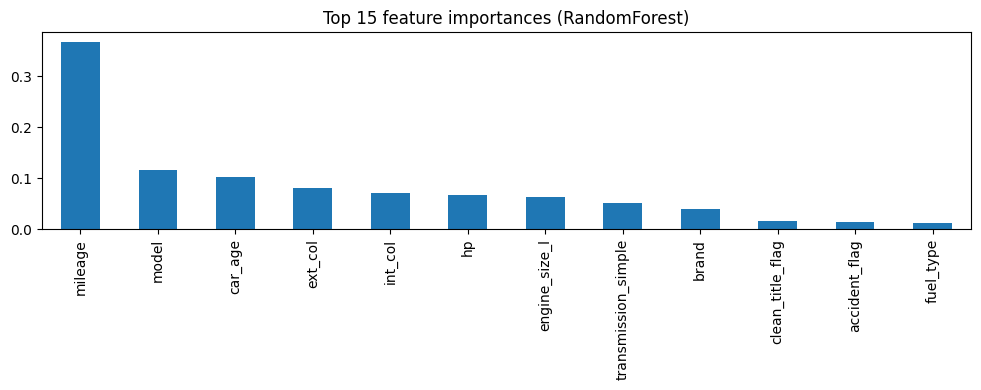

In [ ]:

import matplotlib.pyplot as plt
feat_names = X.columns
importances = rf.feature_importances_
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)

print(fi.head(15))
fi.head(15).plot(kind='bar', figsize=(10,4))
plt.title("Top 15 feature importances (RandomForest)")
plt.tight_layout()
plt.show()